In [ ]:
# Файл с dag в оригинале выполнен как .py файл. Сохранён здесь в виде ipynb чтобы можно было добавить скрины об успешном выполнении из airflow

from airflow import DAG
from airflow.providers.common.sql.operators.sql import SQLExecuteQueryOperator
from airflow.providers.postgres.hooks.postgres import PostgresHook
from airflow.providers.standard.operators.python import PythonOperator
from datetime import datetime, timedelta
import pandas as pd
from airflow.providers.standard.operators.empty import EmptyOperator
import logging

default_args = {
    'owner': 'dags',
    'depends_on_past': False,
    'start_date': datetime(2025, 12, 20),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
}


def load_customers_to_postgres(**context):
    df_customers = pd.read_csv('/opt/airflow/dags/customer.csv', sep=';')
    postgres_hook = PostgresHook(postgres_conn_id='postgres')

    create_table_sql = """
    DROP TABLE IF EXISTS customers;
    CREATE TABLE IF NOT EXISTS customers (
        customer_id INTEGER PRIMARY KEY,
        first_name VARCHAR(100),
        last_name VARCHAR(100),
        gender VARCHAR(20),
        DOB DATE,
        job_title VARCHAR(200),
        job_industry_category VARCHAR(100),
        wealth_segment VARCHAR(50),
        deceased_indicator VARCHAR(1),
        owns_car VARCHAR(3),
        address TEXT,
        postcode VARCHAR(10),
        state VARCHAR(50),
        country VARCHAR(50),
        property_valuation INTEGER,
        load_date DATE DEFAULT CURRENT_DATE,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    );
    """
    postgres_hook.run(create_table_sql)

    create_indexes_sql = [
        "CREATE INDEX IF NOT EXISTS idx_customers_dob ON customers(dob);",
        "CREATE INDEX IF NOT EXISTS idx_customers_state ON customers(state);",
        "CREATE INDEX IF NOT EXISTS idx_customers_postcode ON customers(postcode);"
    ]

    for sql in create_indexes_sql:
        try:
            postgres_hook.run(sql)
        except Exception as e:
            logging.info(f"Индекс уже существует: {e}")

    df_customers.to_sql(
        'customers',
        postgres_hook.get_sqlalchemy_engine(),
        if_exists='replace',
        index=False
    )
    logging.info(f"Загружено {len(df_customers)} записей в таблицу customers")
    return len(df_customers)


def load_order_items_to_postgres(**context):
    df_order_items = pd.read_csv('/opt/airflow/dags/order_items.csv')
    postgres_hook = PostgresHook(postgres_conn_id='postgres')

    create_table_sql = """
    DROP TABLE IF EXISTS order_items;
    CREATE TABLE IF NOT EXISTS order_items (
    order_item_id INTEGER PRIMARY KEY,
    order_id INTEGER,
    product_id INTEGER,
    quantity DECIMAL(10, 2),
    item_list_price_at_sale DECIMAL(10, 2),
    item_standard_cost_at_sale DECIMAL(10, 2),
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    );
    """

    postgres_hook.run(create_table_sql)
    df_order_items.to_sql(
        'order_items',
        postgres_hook.get_sqlalchemy_engine(),
        if_exists='replace',
        index=False
    )
    logging.info(f"Загружено {len(df_order_items)} записей в таблицу order_items")
    return len(df_order_items)


def load_orders_to_postgres(**context):
    df_orders = pd.read_csv('/opt/airflow/dags/orders.csv')
    postgres_hook = PostgresHook(postgres_conn_id='postgres')

    create_table_sql = """
    DROP TABLE IF EXISTS orders;
    CREATE TABLE IF NOT EXISTS orders (
    order_id INTEGER PRIMARY KEY,
    customer_id INTEGER,
    order_date DATE,
    online_order BOOLEAN,
    order_status VARCHAR(50),
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    );
    """

    postgres_hook.run(create_table_sql)
    df_orders.to_sql(
        'orders',
        postgres_hook.get_sqlalchemy_engine(),
        if_exists='replace',
        index=False
    )
    logging.info(f"Загружено {len(df_orders)} записей в таблицу orders")
    return len(df_orders)


def load_product_to_postgres(**context):
    df_product = pd.read_csv('/opt/airflow/dags/product.csv')
    postgres_hook = PostgresHook(postgres_conn_id='postgres')

    create_table_sql = """
    DROP TABLE IF EXISTS products;
    CREATE TABLE IF NOT EXISTS product (
    product_id INTEGER PRIMARY KEY,
    brand VARCHAR(100),
    product_line VARCHAR(50),
    product_class VARCHAR(50),
    product_size VARCHAR(50),
    list_price DECIMAL(10, 2),
    standard_cost DECIMAL(10, 2),
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    );
    """

    postgres_hook.run(create_table_sql)
    df_product.to_sql(
        'product',
        postgres_hook.get_sqlalchemy_engine(),
        if_exists='replace',
        index=False
    )
    logging.info(f"Загружено {len(df_product)} записей в таблицу product")
    return len(df_product)


def save_query1_result(**context):
    hook = PostgresHook(postgres_conn_id='postgres')
    query1_sql = """
    WITH customer_transactions AS (
        SELECT
            c.customer_id,
            c.first_name,
            c.last_name,
            COALESCE(SUM(oi.quantity * oi.item_list_price_at_sale), 0) as total_transaction_amount
        FROM customers c
        LEFT JOIN orders o ON c.customer_id = o.customer_id
        LEFT JOIN order_items oi ON o.order_id = oi.order_id
        GROUP BY c.customer_id, c.first_name, c.last_name
    ),
    ranked_min AS (
        SELECT
            customer_id,
            first_name,
            last_name,
            total_transaction_amount,
            ROW_NUMBER() OVER (ORDER BY total_transaction_amount ASC) as min_rank
        FROM customer_transactions
        WHERE total_transaction_amount > 0
    ),
    ranked_max AS (
        SELECT
            customer_id,
            first_name,
            last_name,
            total_transaction_amount,
            ROW_NUMBER() OVER (ORDER BY total_transaction_amount DESC) as max_rank
        FROM customer_transactions
    )
    SELECT
        'MIN' as transaction_type,
        first_name,
        last_name,
        total_transaction_amount
    FROM ranked_min
    WHERE min_rank <= 3
    UNION ALL
    SELECT
        'MAX' as transaction_type,
        first_name,
        last_name,
        total_transaction_amount
    FROM ranked_max
    WHERE max_rank <= 3
    ORDER BY transaction_type, total_transaction_amount;
    """
    result_df = hook.get_pandas_df(sql=query1_sql)
    output_path = '/opt/airflow/dags/top3_min_max_transactions.csv'
    result_df.to_csv(output_path, index=False)
    logging.info(f"Запрос 1 выполнен. Найдено записей: {len(result_df)}")
    return len(result_df)


def save_query2_result(**context):
    hook = PostgresHook(postgres_conn_id='postgres')
    query2_sql = """
    WITH customer_revenue AS (
        SELECT
            c.customer_id,
            c.first_name,
            c.last_name,
            c.wealth_segment,
            COALESCE(SUM(oi.quantity * oi.item_list_price_at_sale), 0) as total_revenue
        FROM customers c
        LEFT JOIN orders o ON c.customer_id = o.customer_id
        LEFT JOIN order_items oi ON o.order_id = oi.order_id
        GROUP BY c.customer_id, c.first_name, c.last_name, c.wealth_segment
    ),
    ranked_customers AS (
        SELECT
            first_name,
            last_name,
            wealth_segment,
            total_revenue,
            ROW_NUMBER() OVER (
                PARTITION BY wealth_segment
                ORDER BY total_revenue DESC
            ) as rank_in_segment
        FROM customer_revenue
    )
    SELECT
        first_name,
        last_name,
        wealth_segment,
        total_revenue,
        rank_in_segment
    FROM ranked_customers
    WHERE rank_in_segment <= 5
    ORDER BY wealth_segment, rank_in_segment;
    """
    result_df = hook.get_pandas_df(sql=query2_sql)
    output_path = '/opt/airflow/dags/top5_wealth_segment.csv'
    result_df.to_csv(output_path, index=False)
    logging.info(f"Запрос 2 выполнен. Найдено записей: {len(result_df)}")
    return len(result_df)


def check_query1_result(**context):
    ti = context['ti']
    row_count = ti.xcom_pull(task_ids='save_query1_result')
    if row_count == 0:
        logging.warning("ВНИМАНИЕ: Запрос 1 вернул 0 строк!")
        return False
    else:
        logging.info(f"Запрос 1 прошел проверку: {row_count} строк")
        return True


def check_query2_result(**context):
    ti = context['ti']
    row_count = ti.xcom_pull(task_ids='save_query2_result')
    if row_count == 0:
        logging.warning("ВНИМАНИЕ: Запрос 2 вернул 0 строк!")
        return False
    else:
        logging.info(f"Запрос 2 прошел проверку: {row_count} строк")
        return True


def final_dag_status_check(**context):
    ti = context['ti']

    results = {
        'load_customers': ti.xcom_pull(task_ids='load_csv_data_cust_2'),
        'load_order_items': ti.xcom_pull(task_ids='load_csv_data_oi'),
        'load_orders': ti.xcom_pull(task_ids='load_csv_data_o'),
        'load_product': ti.xcom_pull(task_ids='load_csv_data_p'),
        'query1_check': ti.xcom_pull(task_ids='check_query1_result'),
        'query2_check': ti.xcom_pull(task_ids='check_query2_result')
    }

    all_success = all(results.values())

    log_message = f"""
    Статус выполнения:
    - Загрузка customers: {results['load_customers']} записей
    - Загрузка order_items: {results['load_order_items']} записей
    - Загрузка orders: {results['load_orders']} записей
    - Загрузка product: {results['load_product']} записей
    - Проверка запроса 1: {'ПРОЙДЕНА' if results['query1_check'] else 'НЕ ПРОЙДЕНА (0 строк)'}
    - Проверка запроса 2: {'ПРОЙДЕНА' if results['query2_check'] else 'НЕ ПРОЙДЕНА (0 строк)'}
    """

    if all_success:
        success_message = """
    DAG ВЫПОЛНЕН УСПЕШНО!
    Все задачи выполнены, аналитические запросы вернули данные.
    Результаты сохранены в файлы:
    - /opt/airflow/dags/top3_min_max_transactions.csv
    - /opt/airflow/dags/top5_wealth_segment.csv
        """
        logging.info(log_message)
        logging.info(success_message)
        return "SUCCESS"
    else:
        failed_tasks = [key for key, value in results.items() if not value and value is not False]
        error_message = f"""
    DAG ВЫПОЛНЕН С ОШИБКАМИ!
    Не пройдены проверки: {', '.join(failed_tasks) if failed_tasks else 'Одна или несколько проверок не пройдены'}
        """
        logging.warning(log_message)
        logging.warning(error_message)
        return "FAILED"


with DAG(
        'daily_csv_to_postgres_0',
        default_args=default_args,
        description='Ежедневная загрузка CSV в PostgreSQL и аналитические запросы',
        schedule='0 0 * * *',
        catchup=False,
        tags=['a1', 'csv', 'postgres', 'etl', 'analytics'],
) as dag:
    start = EmptyOperator(task_id='start')

    load_data_cust = PythonOperator(
        task_id='load_csv_data_cust_2',
        python_callable=load_customers_to_postgres
    )

    load_data_oi = PythonOperator(
        task_id='load_csv_data_oi',
        python_callable=load_order_items_to_postgres
    )

    load_data_o = PythonOperator(
        task_id='load_csv_data_o',
        python_callable=load_orders_to_postgres
    )

    load_data_p = PythonOperator(
        task_id='load_csv_data_p',
        python_callable=load_product_to_postgres
    )

    save_result1_task = PythonOperator(
        task_id='save_query1_result',
        python_callable=save_query1_result,
    )

    save_result2_task = PythonOperator(
        task_id='save_query2_result',
        python_callable=save_query2_result,
    )

    check_result1_task = PythonOperator(
        task_id='check_query1_result',
        python_callable=check_query1_result,
    )

    check_result2_task = PythonOperator(
        task_id='check_query2_result',
        python_callable=check_query2_result,
    )

    final_status_task = PythonOperator(
        task_id='final_dag_status_check',
        python_callable=final_dag_status_check,
    )

    end = EmptyOperator(task_id='end')

    start >> [load_data_cust, load_data_oi, load_data_o, load_data_p]

    for load_task in [load_data_cust, load_data_oi, load_data_o, load_data_p]:
        load_task >> save_result1_task
        load_task >> save_result2_task

    save_result1_task >> check_result1_task
    save_result2_task >> check_result2_task

    check_result1_task >> final_status_task
    check_result2_task >> final_status_task

    final_status_task >> end

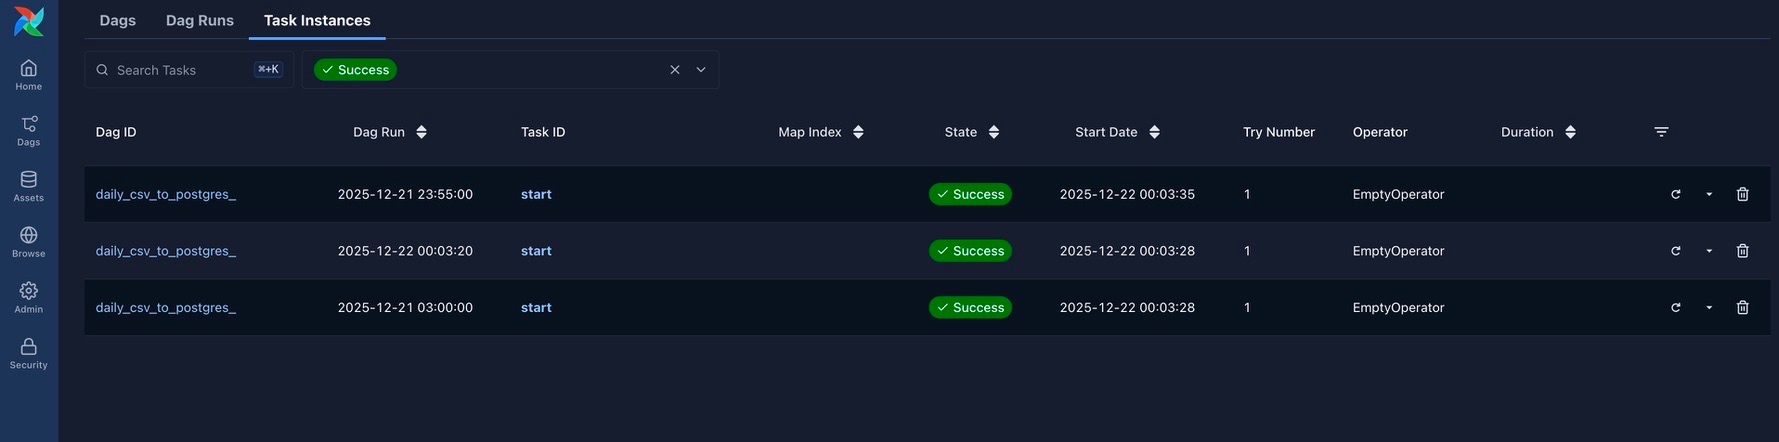

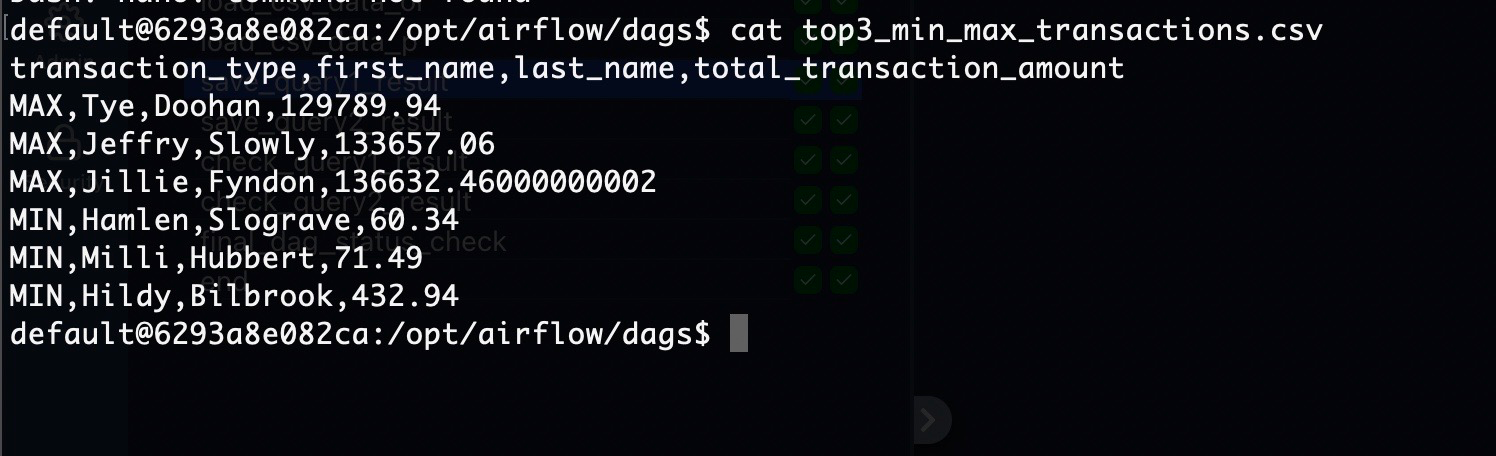

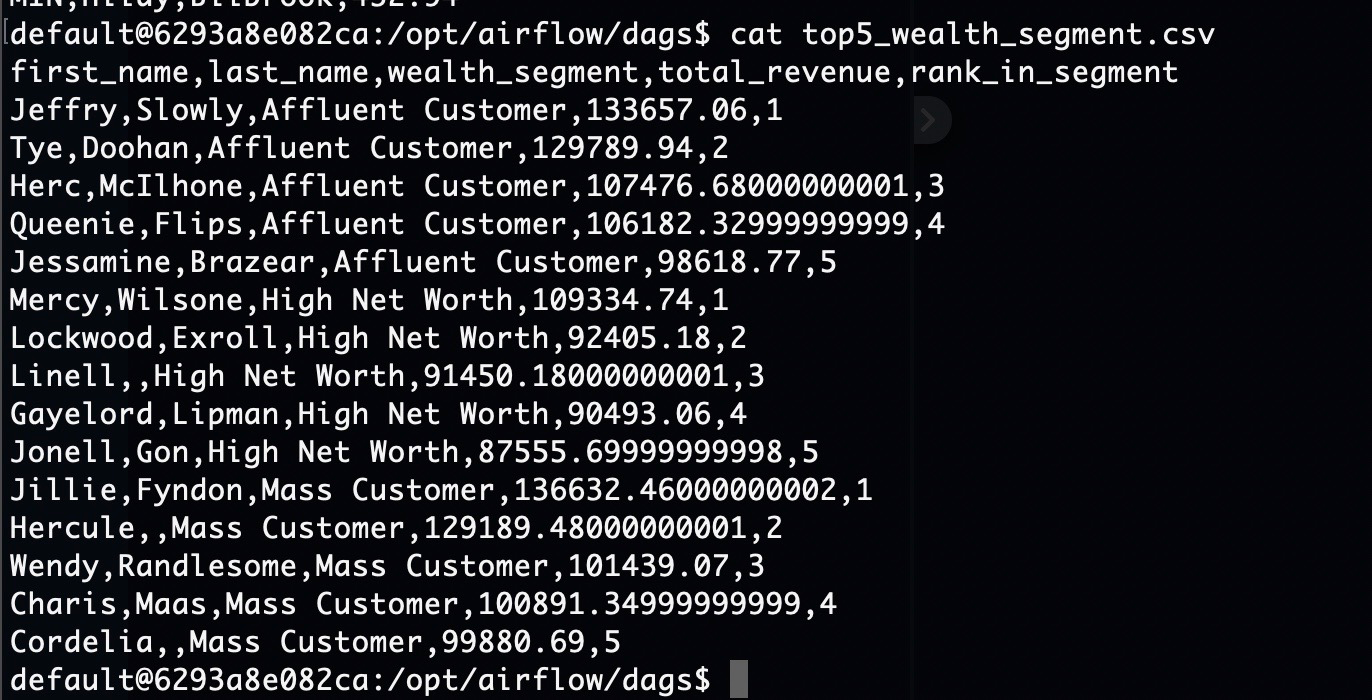

проверка что запрос 1 вернул ненулевое количество строк:
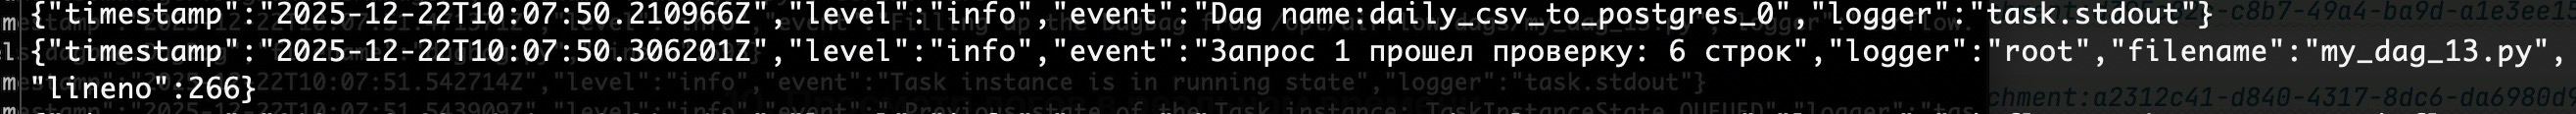

проверка что запрос 2 вернул ненулевое количество строк:
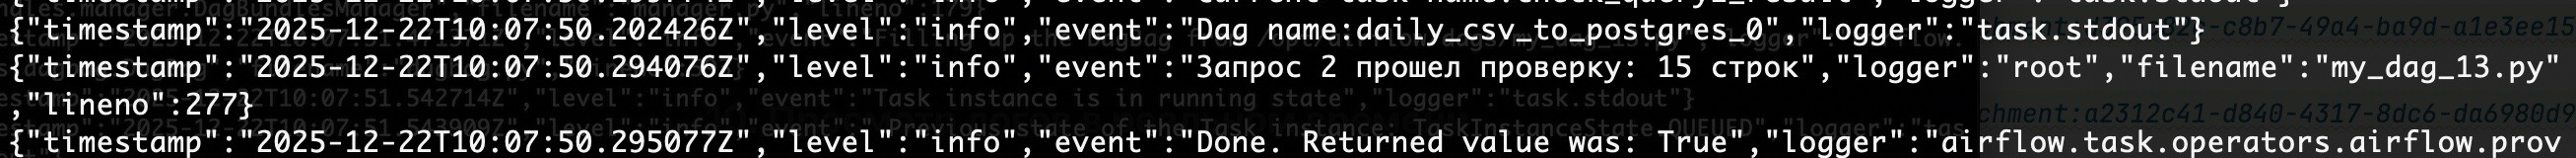

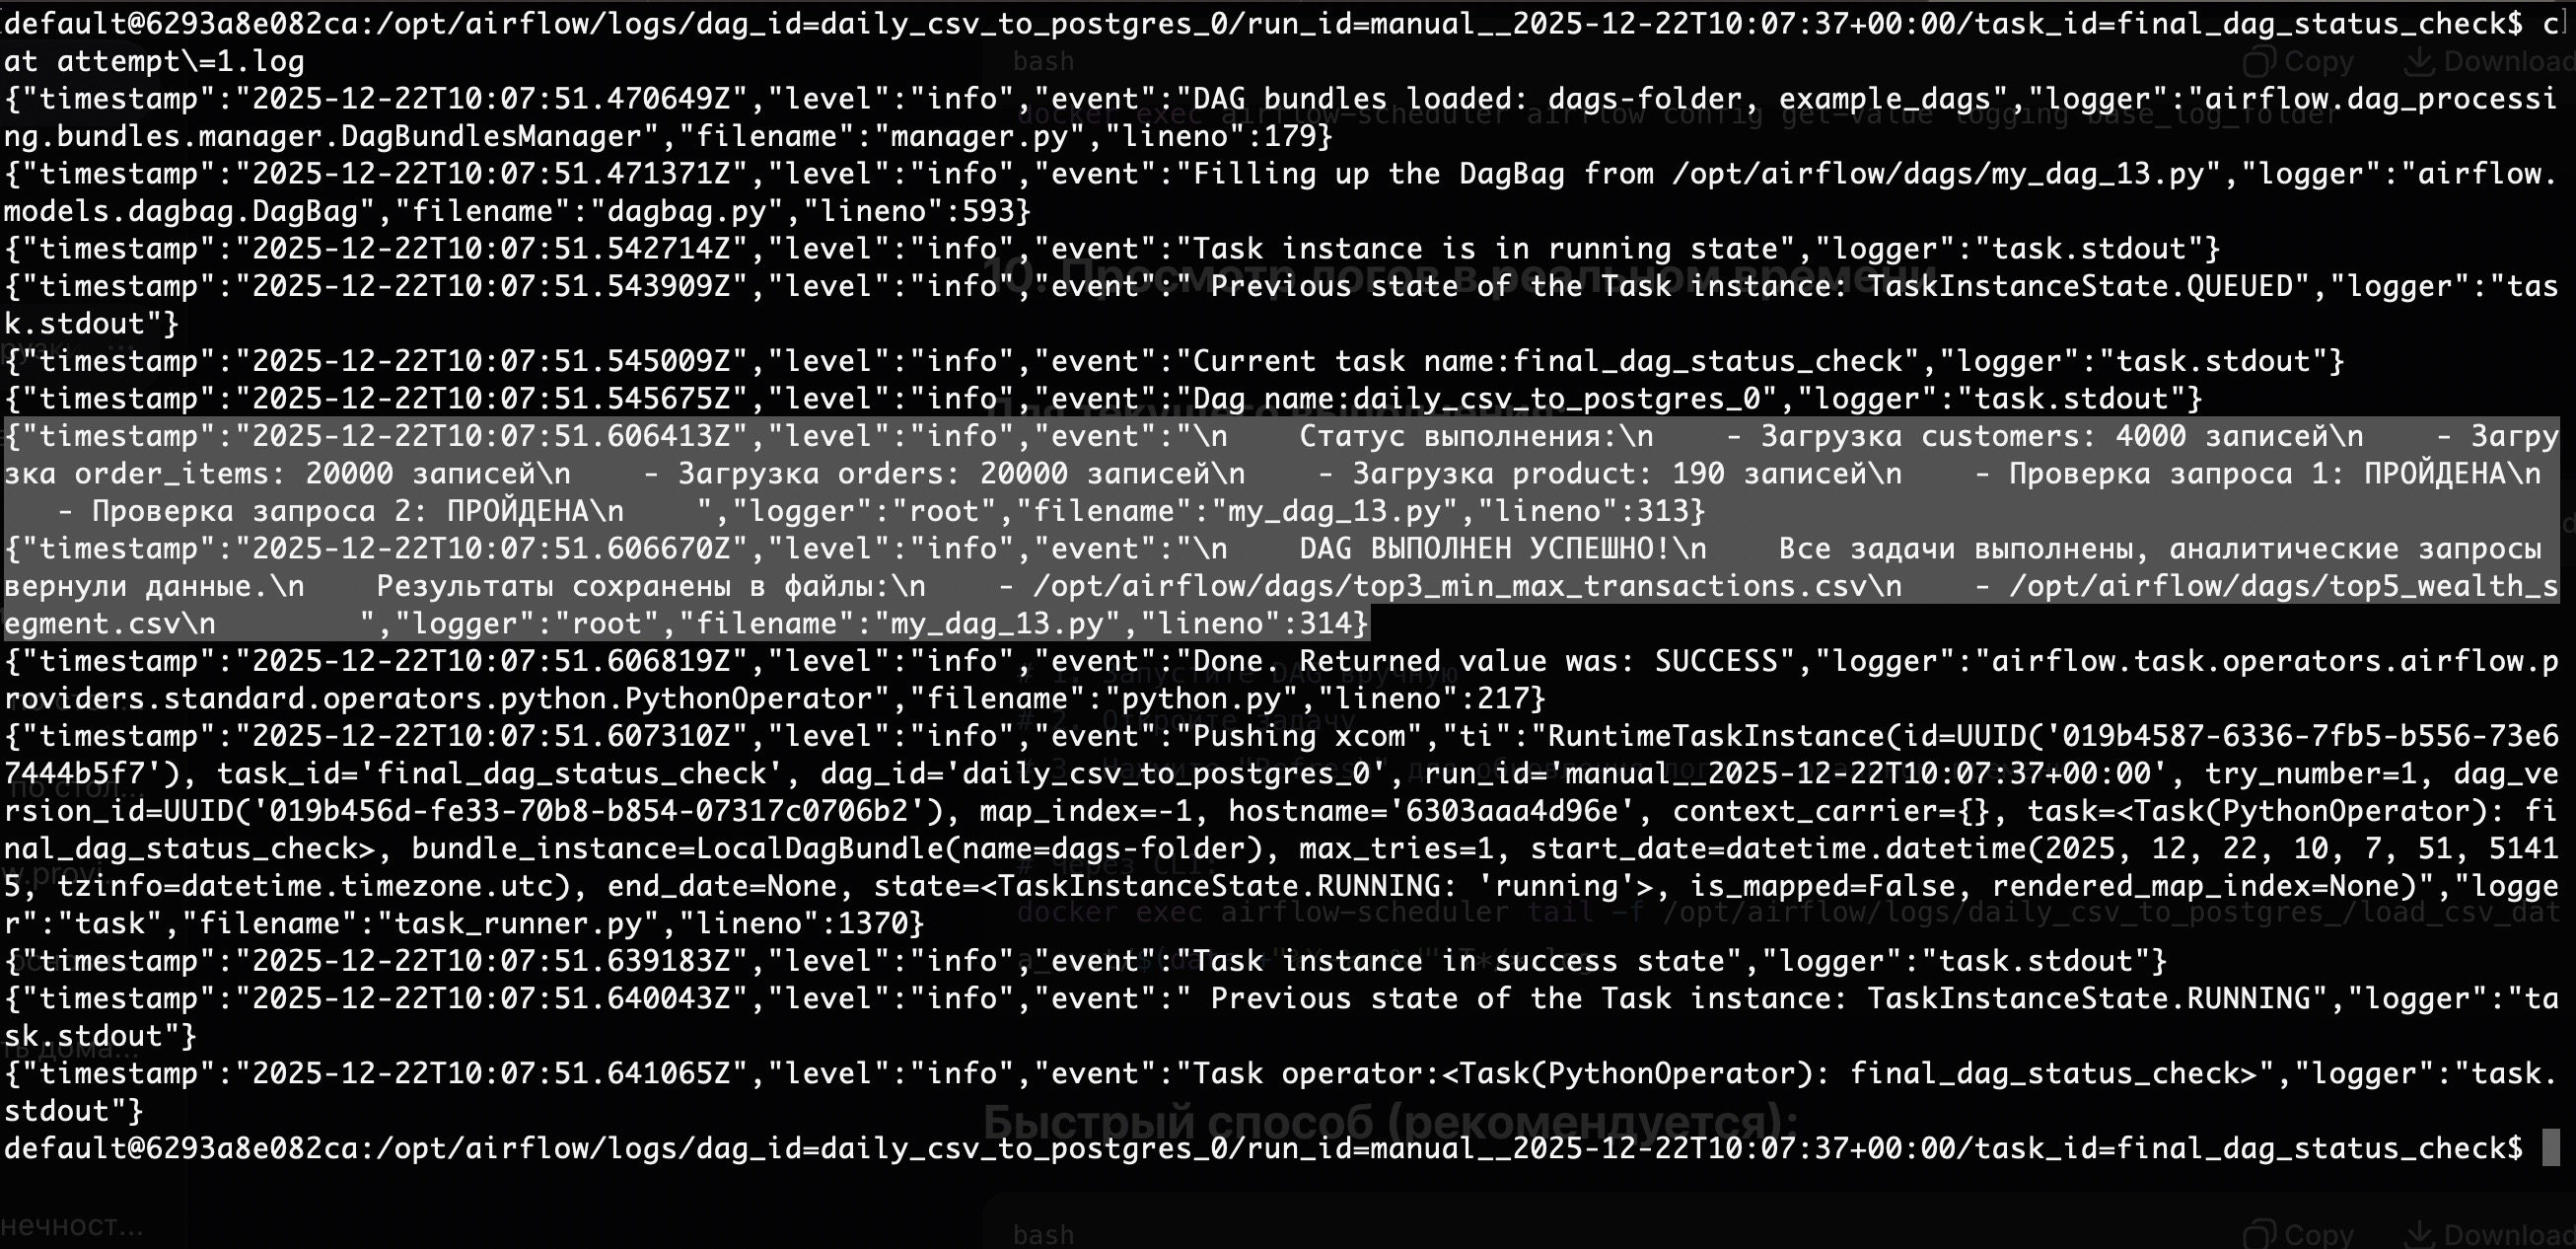

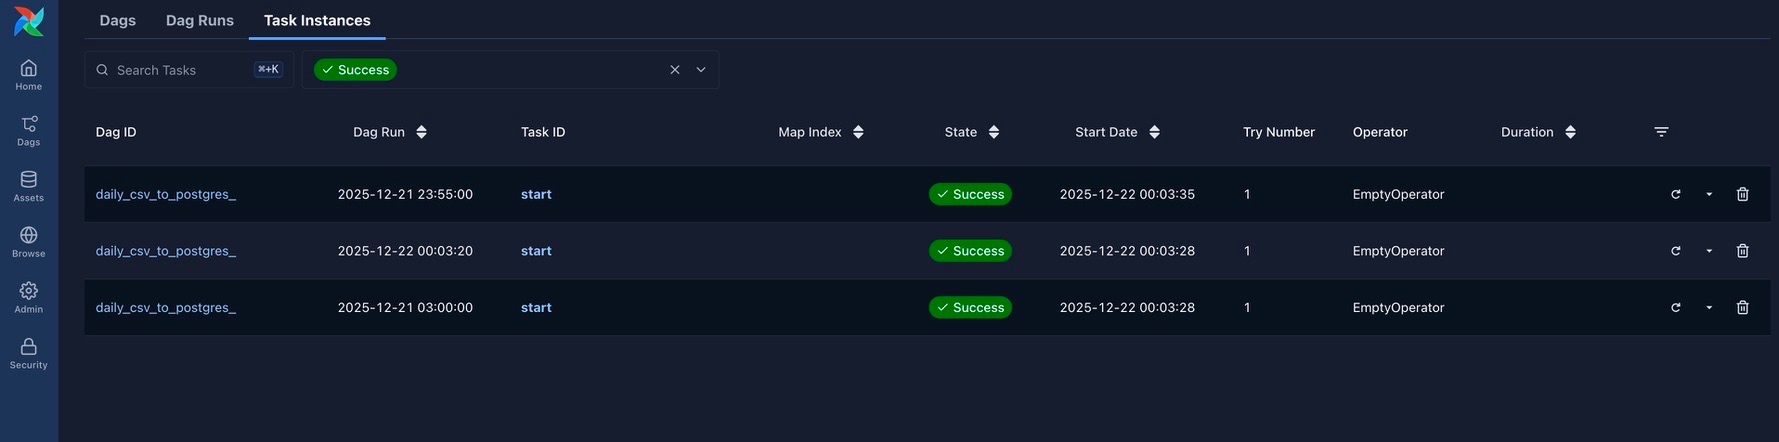